<a href="https://colab.research.google.com/github/MelonieNimasha/Cancer-Cell-Detection/blob/main/forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ModellingExercise/data_forecasting

/content/drive/MyDrive/ModellingExercise/data_forecasting


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from statsmodels.tsa.arima_model import ARIMA
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [5]:
train_data = 'Train.csv'
train_df = pd.read_csv(train_data)

In [17]:
train_df = train_df[["year", "month", "site_code", "product_code", "stock_distributed" ]]
train_df

,year,month,site_code,product_code,stock_distributed
0,2019,1,C4001,AS27134,21
1,2019,1,C4001,AS27132,3
2,2019,1,C4001,AS27000,22
3,2019,1,C4001,AS27137,0
4,2019,1,C4001,AS27138,2
...,...,...,...,...,...
35748,2016,7,C2055,AS27133,25
35749,2016,7,C2055,AS27138,0
35750,2016,7,C2055,AS27132,4
35751,2016,7,C2055,AS27134,8


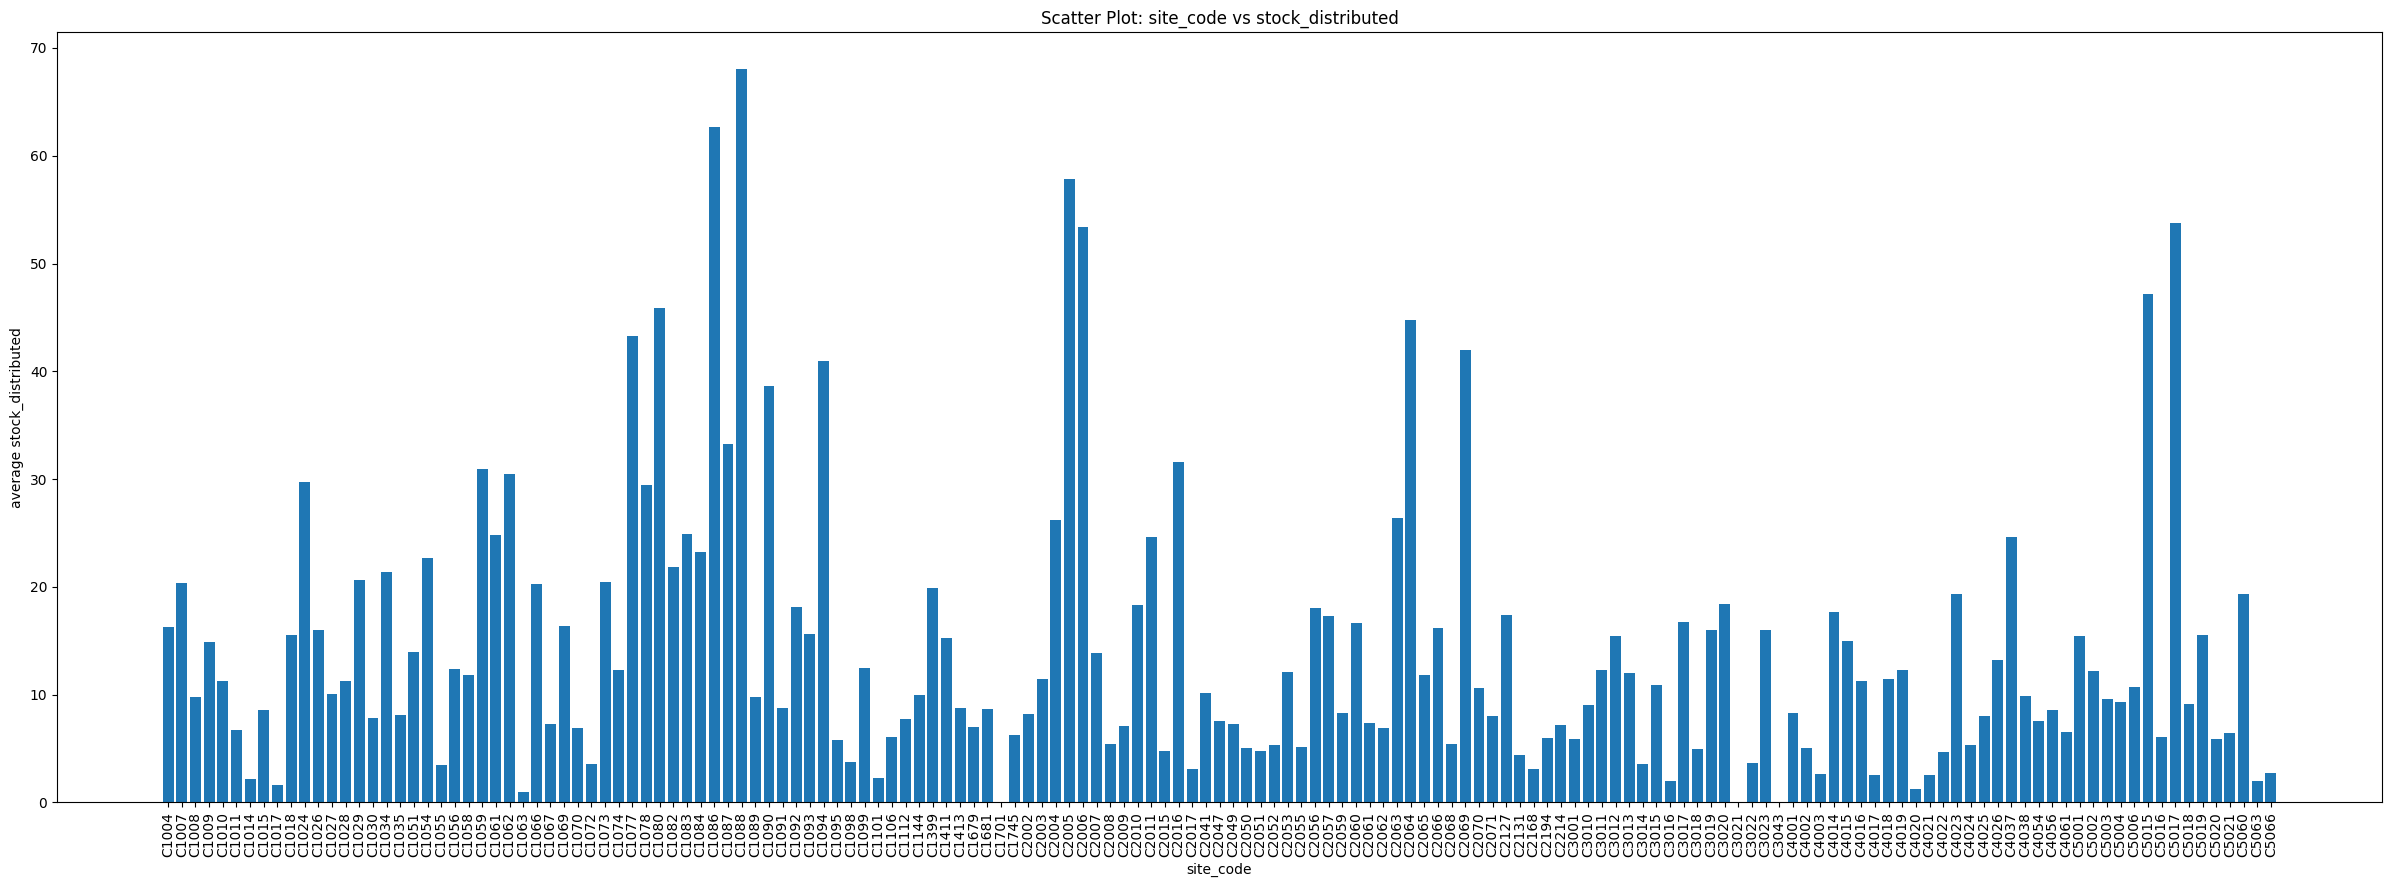

In [18]:
grouped_site_code = train_df.groupby('site_code')['stock_distributed'].mean()
grouped_site_code = grouped_site_code
plt.figure(figsize=(30, 10))
plt.bar(grouped_site_code.index, grouped_site_code.values)
plt.xlabel('site_code')
plt.ylabel('average stock_distributed')
plt.title('Scatter Plot: site_code vs stock_distributed')
plt.xticks(rotation=90)
plt.show()

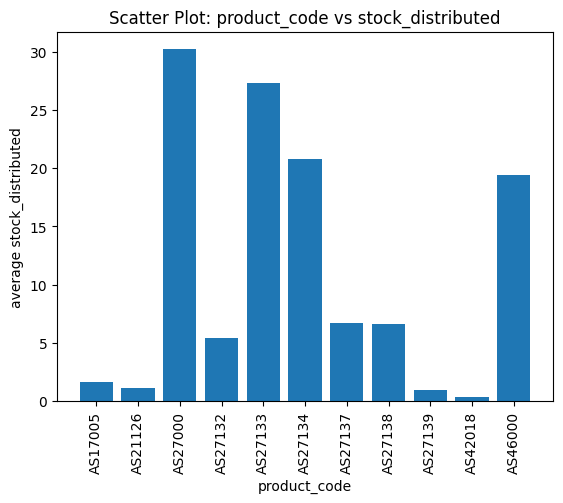

In [19]:
grouped_product_code = train_df.groupby('product_code')['stock_distributed'].mean()

plt.bar(grouped_product_code.index, grouped_product_code.values)
plt.xlabel('product_code')
plt.ylabel('average stock_distributed')
plt.title('Scatter Plot: product_code vs stock_distributed')
plt.xticks(rotation=90)
plt.show()

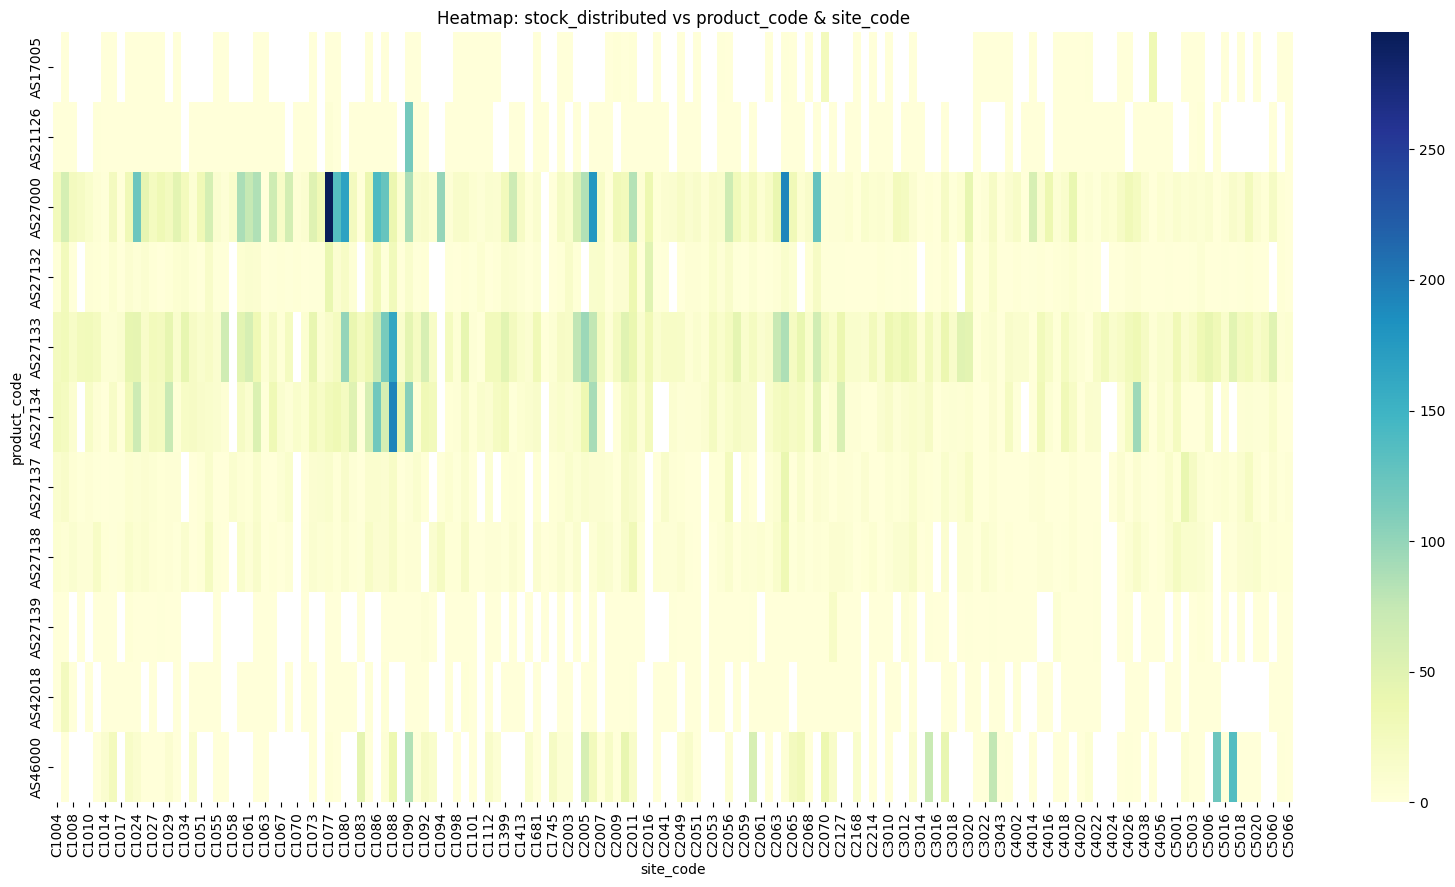

In [20]:
pivot_table = train_df.pivot_table(index='product_code', columns='site_code', values='stock_distributed', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.xlabel('site_code')
plt.ylabel('product_code')
plt.title('Heatmap: stock_distributed vs product_code & site_code')
plt.show()

Dropdown(description='Select Site Code:', options=('C4001', 'C4023', 'C1066', 'C1010', 'C1026', 'C1063', 'C101…

Dropdown(description='Select Product Code:', options=('AS27134', 'AS27132', 'AS27000', 'AS27137', 'AS27138', '…

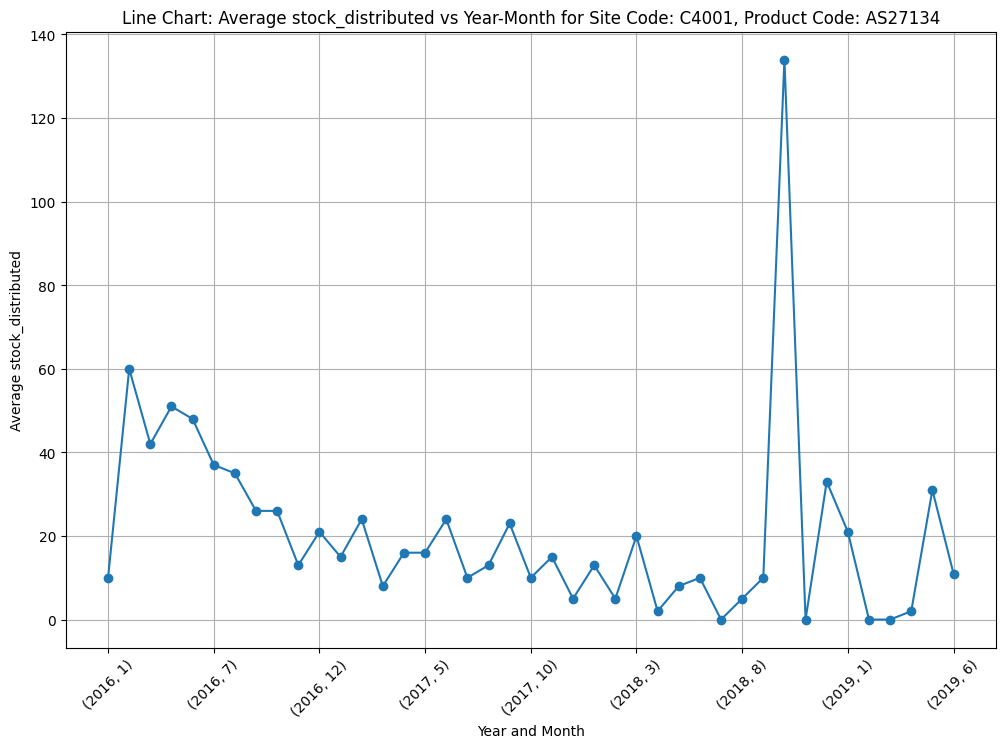

In [21]:
# Create interactive widgets for selecting site_code and product_code
site_selector = widgets.Dropdown(options=train_df['site_code'].unique(), description='Select Site Code:')
product_selector = widgets.Dropdown(options=train_df['product_code'].unique(), description='Select Product Code:')

# Create a function to update the line chart
def update_line_chart(change):
    site = site_selector.value
    product = product_selector.value
    selected_data = train_df[(train_df['product_code'] == product) & (train_df['site_code'] == site)]
    selected_data = selected_data.groupby(['year', 'month'])['stock_distributed'].mean()

    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
    selected_data.plot(marker='o')
    plt.xlabel('Year and Month')
    plt.ylabel('Average stock_distributed')
    plt.title(f'Line Chart: Average stock_distributed vs Year-Month for Site Code: {site}, Product Code: {product}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Attach the function to the widget events
site_selector.observe(update_line_chart, names='value')
product_selector.observe(update_line_chart, names='value')

# Display the widgets
display(site_selector, product_selector)

# Initial line chart with default selections
update_line_chart(None)

In [30]:
pivot_df = train_df.pivot(index=['year', 'month'], columns=['site_code', 'product_code'], values='stock_distributed')
pivot_df = pivot_df.fillna(0)
pivot_df

site_code      C4001                                           C4023          \
product_code AS27134 AS27132 AS27000 AS27137 AS27138 AS27133 AS27000 AS27133   
year month                                                                     
2016 1          10.0     0.0    21.0     0.0     0.0     0.0     0.0     0.0   
     2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     3          60.0     3.0    42.0     0.0     0.0     0.0    20.0     0.0   
     4          42.0     3.0    15.0     0.0     0.0     0.0     0.0     0.0   
     5          51.0     0.0    39.0     0.0     0.0     0.0    30.0     0.0   
     6          48.0     0.0     9.0     0.0     0.0     0.0     0.0     0.0   
     7          37.0     0.0     6.0     0.0     0.0     0.0     0.0     0.0   
     8          35.0     0.0    11.0     1.0     0.0    11.0     0.0     0.0   
     9          26.0     0.0     5.0     0.0     0.0    29.0    20.0     0.0   
     10         26.0     0.0    11.0     0.0     0.0    24.0    20.0    50.0   
     11         13.0     2.0    14.0     0.0     0.0    36.0    10.0     0.0   
     12         21.0     0.0    10.0     0.0     0.0    36.0     0.0    50.0   
2017 1          15.0     0.0     3.0     0.0     0.0    15.0    10.0    50.0   
     2          24.0     0.0    12.0     0.0     0.0    37.0    30.0   125.0   
     3           8.0     6.0     8.0     1.0     0.0    40.0     0.0    25.0   
     4          16.0     0.0     5.0     0.0     0.0    33.0    10.0    50.0   
     5          16.0     0.0    15.0     0.0     0.0    28.0    10.0    50.0   
     6          24.0     0.0    13.0     0.0     0.0    43.0    10.0     0.0   
     7          10.0     0.0     0.0     0.0     0.0    14.0    10.0     0.0   
     8          13.0     2.0     9.0     0.0     0.0     0.0    10.0     0.0   
     9          23.0     4.0    10.0     0.0     0.0     0.0    10.0     0.0   
     10         10.0     0.0    10.0     0.0     0.0     0.0    20.0    50.0   
     11         15.0     0.0     5.0     1.0     0.0     5.0    10.0     0.0   
     12          5.0     0.0     4.0     0.0     0.0     0.0     0.0    25.0   
2018 1          13.0     1.0     3.0     0.0     0.0     0.0    10.0    75.0   
     2           5.0     0.0     4.0     0.0     3.0     0.0     0.0    50.0   
     3          20.0     2.0     4.0     1.0    10.0     0.0    10.0     0.0   
     4           2.0     1.0     8.0     0.0    10.0     0.0    20.0     0.0   
     5           8.0     4.0    12.0     0.0     0.0     0.0     0.0    25.0   
     6          10.0     0.0     0.0     0.0    12.0     0.0    10.0    25.0   
     7           0.0     0.0    11.0     0.0     0.0     0.0    10.0    25.0   
     8           5.0     0.0     5.0     0.0     0.0     5.0    10.0    50.0   
     9          10.0     0.0     1.0     0.0     0.0    32.0    10.0    25.0   
     10        134.0     0.0     6.0     0.0     2.0    12.0    10.0    25.0   
     11          0.0     0.0     6.0     0.0     1.0     0.0    20.0    75.0   
     12         33.0     2.0     0.0     0.0     0.0     0.0    10.0    50.0   
2019 1          21.0     3.0    22.0     0.0     2.0    19.0     0.0    29.0   
     2           0.0     0.0    23.0     0.0     3.0    42.0    20.0    21.0   
     3           0.0     0.0    10.0     0.0     9.0    26.0    20.0    50.0   
     4           2.0     0.0     7.0     1.0     7.0    63.0    20.0    50.0   
     5          31.0     1.0     9.0     1.0     7.0    25.0    10.0    25.0   
     6          11.0     0.0     8.0     0.0     1.0    12.0    20.0    50.0   

site_code      C4001   C4023  ...   C2068   C5004                   C1073  \
product_code AS21126 AS21126  ... AS46000 AS27134 AS17005 AS46000 AS17005   
year month                    ...                                           
2016 1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
     2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
     3        

In [46]:
train_data = pivot_df.iloc[0:36,:]
test_data = pivot_df.iloc[24:,:]

In [68]:
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data.values  # Convert DataFrame to numpy array
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.sequence_length]
        sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
        return sequence_tensor

In [69]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MultivariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [49]:
input_dim = 2  # Number of input features
hidden_dim = 64
num_layers = 2
output_dim = 2  # Number of output features
num_epochs = 100
batch_size = 64
learning_rate = 0.001

In [51]:
sequence_length = 12  # Adjust the sequence length as needed
train_dataset = MultivariateTimeSeriesDataset(data, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [60]:
# Initialize the model, loss function, and optimizer
model = MultivariateLSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [71]:
# Training loop
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, labels = data[:, :-1], data[:, -1]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

TypeError: ignored

In [ ]:
# Testing and prediction
model.eval()
with torch.no_grad():
    test_outputs = model(test_data)